<a href="https://colab.research.google.com/github/AhmadNmatar/Adaptable-Handwritten-digit-Recognition/blob/main/cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining Necessary function for the project


In [16]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

This code is about building a Convolutional Neural Networks for recognizing handwritten digit in 10 different languages.

the dataset include the following languages:
'Arabic', 'Bangla', 'Devanagari', 'English', 'Farsi', 'Kannada', 'Swedish', 'Telugu', 'Tibetan', 'Urdu'

In [5]:
#first we load the dataset
from zipfile import ZipFile
with ZipFile('./MNIST-MIX-all.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_folder')

In [17]:
# calculate two performance metrics for classification tasks: F1-score and Balanced Accuracy Score
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

load_dataset_with_processing function, splite the dataset into train, validation and test sets

In [18]:
def load_dataset_with_processing(input_train_test_fn, num_classes=10):
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # split validation set
    from sklearn.model_selection import train_test_split
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

    # normalize train set, validation set and test set.
    X_train = np.array(X_train, dtype="float") / 255.0
    X_train = X_train.reshape(X_train.shape[0], 28, 28,1 )
    print(X_train.shape)

    X_vali = np.array(X_vali, dtype="float") / 255.0
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28,1 )
    print(X_vali.shape)

    X_test = np.array(X_test, dtype="float") / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28,1 )
    print(X_test.shape)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_vali = keras.utils.to_categorical(y_vali, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_vali, y_vali, X_test, y_test

myGenerator function divid the training set into batches Generates a random permutation of indices and ensures the dataset is shuffled at the start of each epoch.

In [19]:
def myGenerator(X_train, y_train, batch_size):
    total_size = X_train.shape[0]

    while True:
        permutation = list(np.random.permutation(total_size))
        for i in range(total_size//batch_size):
            index = permutation[i * batch_size : (i + 1) * batch_size]
            X_batch = X_train[index]
            y_batch = y_train[index]

            yield X_batch, y_batch



build a Convolutional Nural Network consist of input layer, 3 hidden layers, and output layer

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_CNN(input_shape, num_classes):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output of the convolutional layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(128))
    model.add(Activation("relu"))

    # Optional: Dropout to prevent overfitting (especially if using more data)
    model.add(Dropout(0.5))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation="softmax"))

    model.summary()

    return model




train_fn train the created CNN and save the model that gives the achieve the best val_accuracy during the training


In [21]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):
    import os
    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_CNN(input_shape, num_classes)

    # ModelCheckpoint save the weights of the trained model that gave the highest accuracy during the training
    checkpoint = ModelCheckpoint(checkpoint_dir + 'best.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)


    #Compile Keras Model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    datagen = myGenerator(X_train, y_train, batch_size)

    history = model.fit(datagen,
                        steps_per_epoch = len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[checkpoint, es],
                        verbose=2,
                        validation_data=(X_vali, y_vali))

    # Save the entire model (architecture + weights + optimizer state)
    model.save(checkpoint_dir + 'full_model.keras') #Fixed: Corrected the indentation

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    return model

test the trained model on the test set

In [22]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_CNN(input_shape, num_classes)

    # Compile Keras Model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    # load weights
    model.load_weights(pretrained_weights)

    score = model.evaluate(X_test, y_test, verbose=0)

    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)

    return score[1], f1_score, balanced_accuracy_score  # return accuracies

# Training the model.

In [25]:
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 200

checkpoint_dir = './MNIST_MIX_Trained_Model/'
input_train_test_fn = './dataset_folder/MNIST_MIX_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)




(395688, 28, 28, 1)
(98922, 28, 28, 1)
(107158, 28, 28, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 433,252 (1.65 MB)

 Trainable params: 433,252 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.95463, saving model to ./MNIST_MIX_Trained_Model/best.keras
3091/3091 - 21s - 7ms/step - accuracy: 0.8654 - loss: 0.4979 - val_accuracy: 0.9546 - val_loss: 0.1607
Epoch 2/200

Epoch 2: val_accuracy improved from 0.95463 to 0.96487, saving model to ./MNIST_MIX_Trained_Model/best.keras
3091/3091 - 10s - 3ms/step - accuracy: 0.9130 - loss: 0.3154 - val_accuracy: 0.9649 - val_loss: 0.1331
Epoch 3/200

Epoch 3: val_accuracy did not improve from 0.96487
3091/3091 - 10s - 3ms/step - accuracy: 0.9183 - loss: 0.2984 - val_accuracy: 0.9609 - val_loss: 0.1360
Epoch 4/200

Epoch 4: val_accuracy improved from 0.96487 to 0.96672, saving model to ./MNIST_MIX_Trained_Model/best.keras
3091/3091 - 9s - 3ms/step - accuracy: 0.9219 - loss: 0.2901 - val_accuracy: 0.9667 - val_loss: 0.1187
Epoch 5/200

Epoch 5: val_accuracy did not improve from 0.96672
3091/3091 - 9s - 3ms/step - accuracy: 0.9248 - loss: 0.2775 - val_accuracy: 0.9639 - val_loss: 0.1

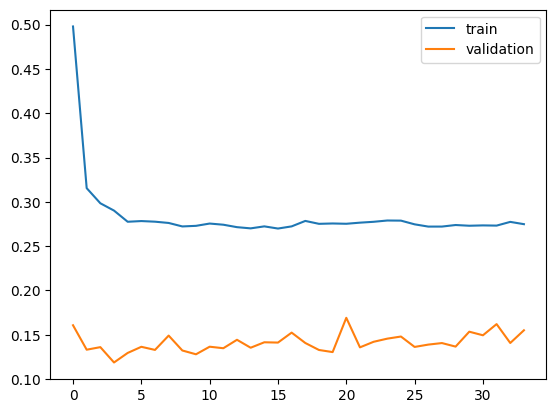

<Sequential name=sequential_1, built=True>

In [26]:
train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [27]:
pretrained_weights = './MNIST_MIX_Trained_Model/best.keras'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 433,252 (1.65 MB)

 Trainable params: 433,252 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

3349/3349 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy:  0.9291700124740601
Weighted F1:  0.9280906327819473
Balanced Accuracy:  0.8607357735109232


# test the trained model


the following list, map each class in the dataset to its corresponding digit and langauge


In [29]:
digit_language_mapping = {
    0: '0 (Arabic)', 1: '1 (Arabic)', 2: '2 (Arabic)', 3: '3 (Arabic)', 4: '4 (Arabic)', 5: '5 (Arabic)', 6: '6 (Arabic)', 7: '7 (Arabic)', 8: '8 (Arabic)', 9: '9 (Arabic)',
    10: '0 (Bangla)', 11: '1 (Bangla)', 12: '2 (Bangla)', 13: '3 (Bangla)', 14: '4 (Bangla)', 15: '5 (Bangla)', 16: '6 (Bangla)', 17: '7 (Bangla)', 18: '8 (Bangla)', 19: '9 (Bangla)',
    20: '0 (Devanagari)', 21: '1 (Devanagari)', 22: '2 (Devanagari)', 23: '3 (Devanagari)', 24: '4 (Devanagari)', 25: '5 (Devanagari)', 26: '6 (Devanagari)', 27: '7 (Devanagari)', 28: '8 (Devanagari)', 29: '9 (Devanagari)',
    30: '0 (English)', 31: '1 (English)', 32: '2 (English)', 33: '3 (English)', 34: '4 (English)', 35: '5 (English)', 36: '6 (English)', 37: '7 (English)', 38: '8 (English)', 39: '9 (English)',
    40: '0 (Farsi)', 41: '1 (Farsi)', 42: '2 (Farsi)', 43: '3 (Farsi)', 44: '4 (Farsi)', 45: '5 (Farsi)', 46: '6 (Farsi)', 47: '7 (Farsi)', 48: '8 (Farsi)', 49: '9 (Farsi)',
    50: '0 (Kannada)', 51: '1 (Kannada)', 52: '2 (Kannada)', 53: '3 (Kannada)', 54: '4 (Kannada)', 55: '5 (Kannada)', 56: '6 (Kannada)', 57: '7 (Kannada)', 58: '8 (Kannada)', 59: '9 (Kannada)',
    60: '0 (Swedish)', 61: '1 (Swedish)', 62: '2 (Swedish)', 63: '3 (Swedish)', 64: '4 (Swedish)', 65: '5 (Swedish)', 66: '6 (Swedish)', 67: '7 (Swedish)', 68: '8 (Swedish)', 69: '9 (Swedish)',
    70: '0 (Telugu)', 71: '1 (Telugu)', 72: '2 (Telugu)', 73: '3 (Telugu)', 74: '4 (Telugu)', 75: '5 (Telugu)', 76: '6 (Telugu)', 77: '7 (Telugu)', 78: '8 (Telugu)', 79: '9 (Telugu)',
    80: '0 (Tibetan)', 81: '1 (Tibetan)', 82: '2 (Tibetan)', 83: '3 (Tibetan)', 84: '4 (Tibetan)', 85: '5 (Tibetan)', 86: '6 (Tibetan)', 87: '7 (Tibetan)', 88: '8 (Tibetan)', 89: '9 (Tibetan)',
    90: '0 (Urdu)', 91: '1 (Urdu)', 92: '2 (Urdu)', 93: '3 (Urdu)', 94: '4 (Urdu)', 95: '5 (Urdu)', 96: '6 (Urdu)', 97: '7 (Urdu)', 98: '8 (Urdu)', 99: '9 (Urdu)'
}

load the trained model

In [31]:
from tensorflow.keras.models import load_model

model = load_model('./MNIST_MIX_Trained_Model/full_model.keras')


Predict function used for testing the trained model, we apply it here on X_test set and print out the result of 10 sampels  

3349/3349 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


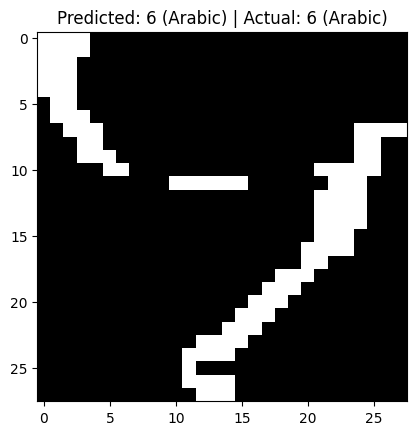

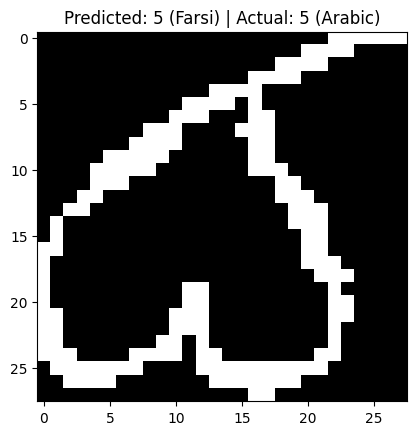

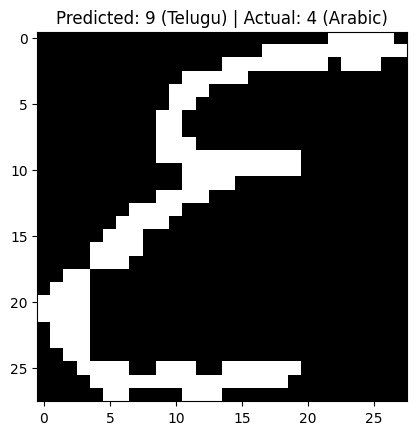

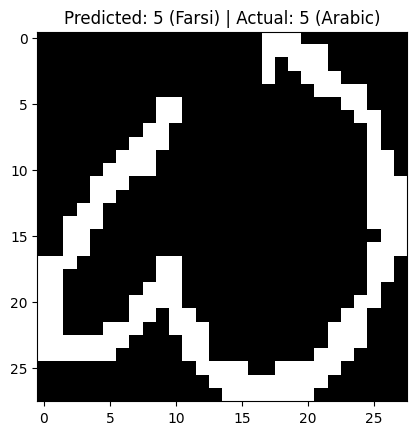

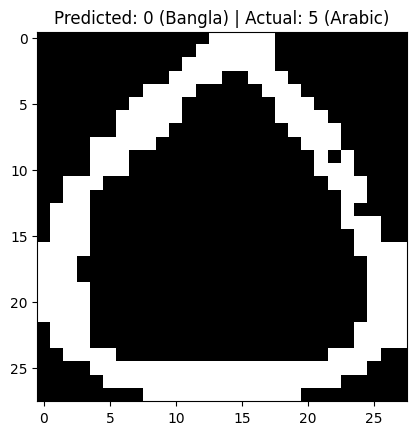

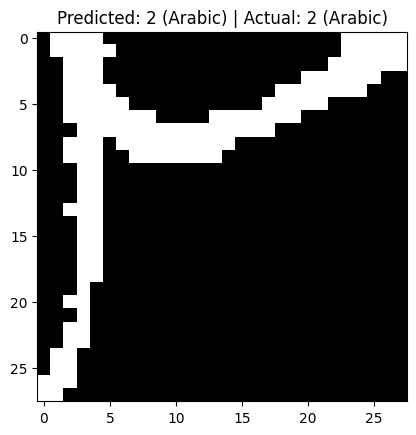

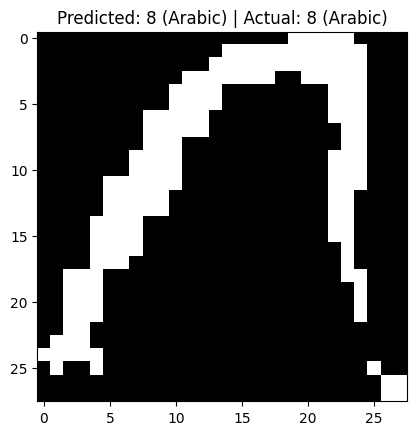

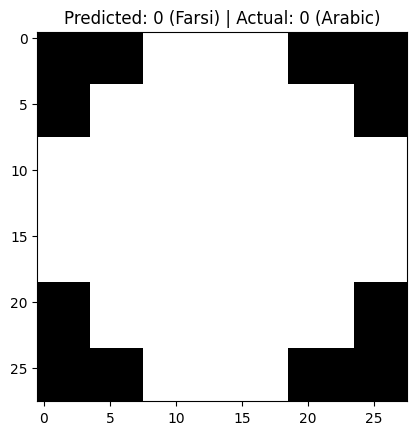

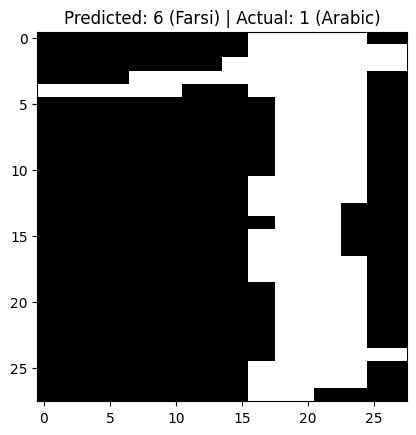

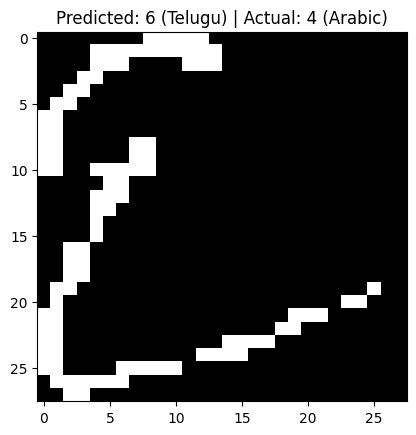

In [32]:
predictions = model.predict(X_test)

for i in range(10):
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    predicted_class = np.argmax(predictions[i])
    actual_class = np.argmax(y_test[i])
    plt.title(f"Predicted: {digit_language_mapping[predicted_class]} | Actual: {digit_language_mapping[actual_class]}")
    plt.show()